En primer lugar, la importación de Numpy, Pandas, RegEx y mi archivo de funciones.

In [12]:
import src.funciones as fc
from pylab import *
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

Importo el dataset y genero las tablas reducidas con las que voy a trabajar. Me interesan los datos de Australia y Sudáfica para la hipótesis.

In [13]:
data = pd.read_csv("input/GSAF5.csv",encoding='cp1252')
display(data)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,ND.0005,Before 1903,0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,FATAL,Y,NaN,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6,NaN,NaN
5988,ND.0004,Before 1903,0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,FATAL,Y,NaN,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5,NaN,NaN
5989,ND.0003,1900-1905,0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,FATAL,Y,NaN,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4,NaN,NaN
5990,ND.0002,1883-1889,0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,FATAL,Y,NaN,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3,NaN,NaN


In [14]:
australia = data[(data["Country"]== "AUSTRALIA")]
sudafrica = data[(data["Country"]== "SOUTH AFRICA")]
aus = australia[["Country","Date", "Year", "Type", "Activity", "Injury", "Fatal (Y/N)"]].rename(columns={"Fatal (Y/N)": "Fatal"})
sud = sudafrica[["Country","Date", "Year", "Type", "Activity", "Injury", "Fatal (Y/N)"]].rename(columns={"Fatal (Y/N)": "Fatal"})
#Aprovecho para cambiar el nombre de la columna fatal cuando creo las tablas, así trabajaré mejor con ella.

Como voy he generado nuevas tablas (Sudáfrica y Australia), me interesa que tengan su propio índice para poder acceder a los registros.

In [15]:
aus = aus.reset_index(drop=True)
sud = sud.reset_index(drop=True)

Voy a empezar limpiando las tablas para organizar los accidentes por fechas. Quiero ver los años más antiguos para ver desde donde empiezan los registros.

In [16]:
display(aus.groupby('Year').count())
display(sud.groupby('Year').count())

,Country,Date,Type,Activity,Injury,Fatal
Year,,,,,,
0,16,16,16,13,15,16
5,1,1,1,0,1,1
1788,1,1,1,1,1,1
1791,1,1,1,0,1,1
1803,1,1,1,0,1,1
...,...,...,...,...,...,...
2012,26,26,26,25,26,26
2013,20,20,20,19,20,20
2014,29,29,29,28,29,29


,Country,Date,Type,Activity,Injury,Fatal
Year,,,,,,
0,8,8,8,8,8,8
1852,2,2,2,2,2,2
1862,2,2,2,1,2,2
1863,1,1,1,1,1,1
1865,1,1,1,1,1,1
...,...,...,...,...,...,...
2012,5,5,5,5,5,5
2013,8,8,8,8,8,8
2014,5,5,5,5,5,5


Mirando los datos de los años de Australia, veo que todos los años son coherentes hasta 1788 en los que encuentro 0. 
En el caso de Sudáfrica es por debajo del 1852 cuando encuentro registros con año 0.
Así que voy a utilizar regex para encontrar un año de referencia y voy a asignarle a la columna date un año menos del que encuentre en la descripción. Será un valor aproximado. Después cruzaré los registros de esas columnas con los que en Year tengan año 0.

In [17]:
aus["Date"] = aus["Date"].apply(fc.limpiadate)  
sud["Date"] = sud["Date"].apply(fc.limpiadate)  

Sustituyo los valores 0 de Year por los que hay en la columna Date 

In [18]:
aus.loc[aus['Year'] == 0, "Year"] = aus["Date"]
sud.loc[sud['Year']== 0, "Year"] = sud["Date"]

In [19]:
display(sud)

,Country,Date,Year,Type,Activity,Injury,Fatal
0,SOUTH AFRICA,0,2016,Unprovoked,Spearfishing,Injuries to left leg & right hand,N
1,SOUTH AFRICA,0,2016,Unprovoked,Surf-skiing,"No injury, surf-ski bitten",N
2,SOUTH AFRICA,0,2016,Boat,Kayak fishing,"No injury, shark capsized kayak",N
3,SOUTH AFRICA,0,2015,Boat,Kayak Fishing,"No injury, kayak damaged",N
4,SOUTH AFRICA,0,2015,Unprovoked,Swimming / Wading,Lacerations to both hands and forearms,N
...,...,...,...,...,...,...,...
560,SOUTH AFRICA,0,0,Unprovoked,Swimming in pool formed by construction of a w...,"FATAL, leg severed",Y
561,SOUTH AFRICA,1920,1920,Unprovoked,Crew swimming alongside their anchored ship,FATAL,Y
562,SOUTH AFRICA,1920,1920,Unprovoked,4 men were bathing,FATAL,Y
563,SOUTH AFRICA,1912,1912,Unprovoked,Fishing,"FATAL, body not recovered but shark was caught...",Y


In [20]:
display(aus)

,Country,Date,Year,Type,Activity,Injury,Fatal
0,AUSTRALIA,0,2016,Unprovoked,Surfing,Struck by fin on chest & leg,N
1,AUSTRALIA,0,2016,Unprovoked,Surfing,No injury: Knocked off board by shark,N
2,AUSTRALIA,0,2016,Boat,Fishing,Shark rammed boat. No injury to occupant,N
3,AUSTRALIA,0,2016,Unprovoked,Surfing,"No inury, board broken in half by shark",N
4,AUSTRALIA,0,2016,Boat,Kayaking,"No injury, shark nudged kayak repeatedly",N
...,...,...,...,...,...,...,...
1274,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y
1275,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y
1276,AUSTRALIA,1905,1905,Unprovoked,Swimming,FATAL,Y
1277,AUSTRALIA,1902,1902,Unprovoked,Diving,FATAL,Y


Elimino los valores que son 0 porque no he encontrado en "Date" ninguna referencia que asignarles. Para terminar de limpiar los años.

In [21]:
aus = aus.drop(aus[aus['Year']==0].index)
sud = sud.drop(sud[sud['Year']==0].index)
#Hacemos unos print de comprobación con el valor mínimo y  máximo de la columna "Year"
print (f'En Australia el primer año registrado es {min(aus["Year"])} y el último {max(aus["Year"])}')
print (f'En Sudáfrica el primer año registrado es {min(sud["Year"])} y el último {max(sud["Year"])}')

En Australia el primer año registrado es 5 y el último 2016
En Sudáfrica el primer año registrado es 1852 y el último 2016


Ahora, para valorar el nivel de agresividad de los tiburones, voy a crear una copia de la columna Injury para trabajar con ella y una nueva columna llamada "Score", donde puntuaré los ataques del 1 al 3. 
Los ataques fatales tendrán directamente la puntuación máxima. Después valoraré con 1 a los que la columna "Injury" devuelva "sin daños" o "laceraciones" y 2 al resto de casos.
Creo las columnas y les paso una fórmula que sustituye "Y" por valor 3.

In [22]:
aus["Score"] = aus['Fatal']
sud["Score"] = sud['Fatal']
aus["Score"] = aus["Score"].apply(fc.asigna3)  
sud["Score"] = sud["Score"].apply(fc.asigna3)

In [23]:
display(aus, sud)

,Country,Date,Year,Type,Activity,Injury,Fatal,Score
0,AUSTRALIA,0,2016,Unprovoked,Surfing,Struck by fin on chest & leg,N,N
1,AUSTRALIA,0,2016,Unprovoked,Surfing,No injury: Knocked off board by shark,N,N
2,AUSTRALIA,0,2016,Boat,Fishing,Shark rammed boat. No injury to occupant,N,N
3,AUSTRALIA,0,2016,Unprovoked,Surfing,"No inury, board broken in half by shark",N,N
4,AUSTRALIA,0,2016,Boat,Kayaking,"No injury, shark nudged kayak repeatedly",N,N
...,...,...,...,...,...,...,...,...
1274,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y,3
1275,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y,3
1276,AUSTRALIA,1905,1905,Unprovoked,Swimming,FATAL,Y,3
1277,AUSTRALIA,1902,1902,Unprovoked,Diving,FATAL,Y,3


,Country,Date,Year,Type,Activity,Injury,Fatal,Score
0,SOUTH AFRICA,0,2016,Unprovoked,Spearfishing,Injuries to left leg & right hand,N,N
1,SOUTH AFRICA,0,2016,Unprovoked,Surf-skiing,"No injury, surf-ski bitten",N,N
2,SOUTH AFRICA,0,2016,Boat,Kayak fishing,"No injury, shark capsized kayak",N,N
3,SOUTH AFRICA,0,2015,Boat,Kayak Fishing,"No injury, kayak damaged",N,N
4,SOUTH AFRICA,0,2015,Unprovoked,Swimming / Wading,Lacerations to both hands and forearms,N,N
...,...,...,...,...,...,...,...,...
558,SOUTH AFRICA,1966,1966,Unprovoked,Crossing river on a raft,"FATAL, leg severed",Y,3
561,SOUTH AFRICA,1920,1920,Unprovoked,Crew swimming alongside their anchored ship,FATAL,Y,3
562,SOUTH AFRICA,1920,1920,Unprovoked,4 men were bathing,FATAL,Y,3
563,SOUTH AFRICA,1912,1912,Unprovoked,Fishing,"FATAL, body not recovered but shark was caught...",Y,3


Ahora toca trabajar con la columna "Injury" para poder asignar el resto de puntuaciones.
Considero todo lo que es "minor" y "laceraciones" como ataque de agresividad bajo (1)
Considero todo lo que es "fatal" como agresividad alta (3)
Todo lo que queda, se le asigna un valor medio (2) normalmente mordeduras, miembros y algunas filas "sin datos".
Voy a hacer una copia de la columna "Injury" porque después machacaré datos con puntuaciones y así puedo mantener la original

In [29]:
aus["Injurycop"] = aus["Injury"]
sud["Injurycop"] = sud["Injury"]

In [30]:
aus["Injurycop"] = aus["Injurycop"].apply(fc.asignapuntos)  
sud["Injurycop"] = sud["Injurycop"].apply(fc.asignapuntos)

In [31]:
display(sud, aus)

,Country,Date,Year,Type,Activity,Injury,Fatal,Score,Injurycop
0,SOUTH AFRICA,0,2016,Unprovoked,Spearfishing,Injuries to left leg & right hand,N,N,2
1,SOUTH AFRICA,0,2016,Unprovoked,Surf-skiing,"No injury, surf-ski bitten",N,N,1
2,SOUTH AFRICA,0,2016,Boat,Kayak fishing,"No injury, shark capsized kayak",N,N,1
3,SOUTH AFRICA,0,2015,Boat,Kayak Fishing,"No injury, kayak damaged",N,N,1
4,SOUTH AFRICA,0,2015,Unprovoked,Swimming / Wading,Lacerations to both hands and forearms,N,N,1
...,...,...,...,...,...,...,...,...,...
558,SOUTH AFRICA,1966,1966,Unprovoked,Crossing river on a raft,"FATAL, leg severed",Y,3,3
561,SOUTH AFRICA,1920,1920,Unprovoked,Crew swimming alongside their anchored ship,FATAL,Y,3,3
562,SOUTH AFRICA,1920,1920,Unprovoked,4 men were bathing,FATAL,Y,3,3
563,SOUTH AFRICA,1912,1912,Unprovoked,Fishing,"FATAL, body not recovered but shark was caught...",Y,3,3


,Country,Date,Year,Type,Activity,Injury,Fatal,Score,Injurycop
0,AUSTRALIA,0,2016,Unprovoked,Surfing,Struck by fin on chest & leg,N,N,2
1,AUSTRALIA,0,2016,Unprovoked,Surfing,No injury: Knocked off board by shark,N,N,1
2,AUSTRALIA,0,2016,Boat,Fishing,Shark rammed boat. No injury to occupant,N,N,1
3,AUSTRALIA,0,2016,Unprovoked,Surfing,"No inury, board broken in half by shark",N,N,1
4,AUSTRALIA,0,2016,Boat,Kayaking,"No injury, shark nudged kayak repeatedly",N,N,1
...,...,...,...,...,...,...,...,...,...
1274,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y,3,3
1275,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y,3,3
1276,AUSTRALIA,1905,1905,Unprovoked,Swimming,FATAL,Y,3,3
1277,AUSTRALIA,1902,1902,Unprovoked,Diving,FATAL,Y,3,3


Igualamos los valores asignados a las lesiones en la columna "Score" para los que no tienen un valor asignado aún.

In [32]:
aus.loc[aus["Score"] == "N", "Score"] = aus["Injurycop"]
sud.loc[sud["Score"] == "N", "Score"] = sud["Injurycop"]

Hago unas tablas de testeo para coger unos index aleatorios y mirar si tiene sentido la limpieza que he hecho con la función. 

In [34]:
prueba = aus[(aus["Injurycop"]== "1")]
prueba2 = aus[(aus["Injurycop"]== "2")]
prueba3 = aus[(aus ["Fatal"]== "Y")]
display(prueba[50:70])
display(prueba2[10:30])
display(prueba3)

,Country,Date,Year,Type,Activity,Injury,Fatal,Score,Injurycop
81,AUSTRALIA,0,2014,Provoked,Fishing,Lacerations to ring and pinky fingers of his l...,N,1,1
82,AUSTRALIA,0,2013,Unprovoked,Surfing,"Puncture wounds to hand, laceration to leg",N,1,1
85,AUSTRALIA,0,2013,Unprovoked,Surfing,"No injury, board bumped by shark",N,1,1
86,AUSTRALIA,0,2013,Unprovoked,Snorkeling,Lacerations to right arm,N,1,1
87,AUSTRALIA,0,2013,Unprovoked,Diving for crayfish,"No injury, swim fin shredded",N,1,1
90,AUSTRALIA,2012,2013,Unprovoked,Wrangling a shark,Lacerations to left forearm,N,1,1
91,AUSTRALIA,0,2013,Unprovoked,Body surfing,"No injury, holes in wetsuit",N,1,1
92,AUSTRALIA,0,2013,Unprovoked,Surfing,"No injury, board damaged",N,1,1
94,AUSTRALIA,0,2013,Unprovoked,Fishing,Puncture wounds and lacerations to both legs,N,1,1
97,AUSTRALIA,0,2013,Unprovoked,Spearfishing,Laceration to left hand,N,1,1


,Country,Date,Year,Type,Activity,Injury,Fatal,Score,Injurycop
37,AUSTRALIA,0,2015,Unprovoked,Surfing,Hand bitten,N,2,2
39,AUSTRALIA,0,2015,Invalid,Surfing,"Bruises and abrasions to face, chin, chest, bo...",N,2,2
40,AUSTRALIA,0,2015,Unprovoked,Surfing,Injuries to left arm & right hand,N,2,2
41,AUSTRALIA,0,2015,Unprovoked,Surfing,Leg severed at mid-thigh,N,2,2
43,AUSTRALIA,0,2015,Unprovoked,Paddle boarding,Ankle injured,N,2,2
44,AUSTRALIA,0,2015,Boat,Fishing,Bruised in falling overboard as shark bumped boat,N,2,2
50,AUSTRALIA,0,2015,Invalid,Surfing & filming dolphins,Board snapped in two,N,2,2
52,AUSTRALIA,0,2015,Unprovoked,Filming,Bitten on hand & wrist,N,2,2
72,AUSTRALIA,0,2014,Provoked,Teasing a shark,Cut to tip of finger by a captive shark PROVOK...,N,2,2
76,AUSTRALIA,0,2014,Invalid,Diving for lobsters,Shark bites may have been post mortem,Y,3,2


,Country,Date,Year,Type,Activity,Injury,Fatal,Score,Injurycop
10,AUSTRALIA,0,2016,Unprovoked,Diving,FATAL,Y,3,3
12,AUSTRALIA,0,2016,Unprovoked,Surfing,FATAL,Y,3,3
33,AUSTRALIA,0,2015,Unprovoked,Scallop diving on hookah,FATAL,Y,3,3
45,AUSTRALIA,0,2015,Unprovoked,Surfing,FATAL,Y,3,3
54,AUSTRALIA,0,2014,Unprovoked,Spearfishing,FATAL,Y,3,3
...,...,...,...,...,...,...,...,...,...
1274,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y,3,3
1275,AUSTRALIA,1905,1905,Unprovoked,Fishing,FATAL,Y,3,3
1276,AUSTRALIA,1905,1905,Unprovoked,Swimming,FATAL,Y,3,3
1277,AUSTRALIA,1902,1902,Unprovoked,Diving,FATAL,Y,3,3


Convierto los valores de la columna "Score" en enteros

In [35]:
aus["Score"] = aus["Score"].apply(fc.casteascore)  
sud["Score"] = sud["Score"].apply(fc.casteascore)

In [36]:
sud["Decadas"] = pd.cut(sud.Year,bins=[1899,1909,1919,1929,1939,1949,1959,1969,1979,1989,1999,2009,2019], labels=range(1900,2020,10))

Divido los años por décadas. Sumando los registros que hay por cada año y haciendo la media del "Score" para ver la agresividad en comparación con la década.

In [40]:
aus["Decadas"] = pd.cut(aus.Year,bins=[1899,1909,1919,1929,1939,1949,1959,1969,1979,1989,1999,2009,2019], labels=range(1900,2020,10))

Voy a unificar las dos tablas quedándome con las columnas "Décadas", "Year", "Score" para sacar gráficos que muestren la cantidad de ataques y su agresividad para las conclusiones.

In [41]:
sudgr = sud[["Country","Decadas", "Year", "Score"]]
ausgr = aus[["Country","Decadas", "Year", "Score"]]

Hago una tabla concatenando las anteriores para extraer datos. Del total de ataques ¿porcentaje se da en Australia y Sudáfrica?

Total de los datos de los ataques en Australia y South Africa desde 1900 hasta 2016


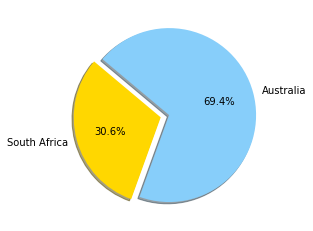

In [44]:
total = pd.concat([ausgr, sudgr])
labels = total["Country"].value_counts()
datos = list(set(labels))
labels = "South Africa","Australia"
colors = ['gold', 'lightskyblue']
explode = (0.1, 0) 
grafico = plt.pie(datos, labels=labels,colors=colors,explode=explode,
autopct='%1.1f%%', shadow=True, startangle=140)
print("Total de los datos de los ataques en Australia y South Africa desde 1900 hasta 2016")

Hago un gráfico de barras con subplot que muestra la cantidad de ataques de ambos países en las mismas décadas.


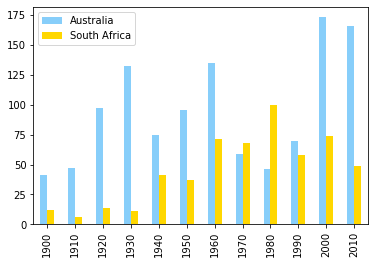

In [45]:
ausval= list(aus.Decadas\
            .value_counts() \
            .reset_index() \
            .sort_values('index', ascending=True) \
            .reset_index(drop=False) \
            .set_index('index')["Decadas"])
sudval= list(sud.Decadas\
            .value_counts() \
            .reset_index() \
            .sort_values('index', ascending=True) \
            .reset_index(drop=False) \
            .set_index('index')["Decadas"])
decadas = ["1900","1910","1920","1930","1940","1950","1960","1970","1980","1990","2000","2010",]
ataques = pd.DataFrame(ausval, index=decadas, columns=["Australia"])
ataques["South Africa"] = sudval
ax = ataques.plot.bar(color = ['lightskyblue','gold'])

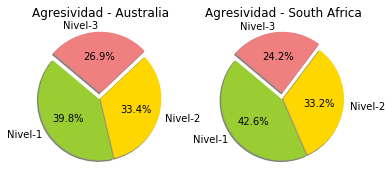

In [46]:
subplot(121)
scoreaustr = aus["Score"].value_counts()
dats = list(scoreaustr)
scores = "Nivel-1", "Nivel-2", "Nivel-3"
colors = 'yellowgreen','gold', 'lightcoral'
explode = (0.02, 0,0.1) 
grafaus = plt.pie(dats, labels=scores,colors=colors,explode=explode,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Agresividad - Australia")
subplot(122)
scoresud = sud["Score"].value_counts()
dats = list(scoresud)
explode = (0.02,0,0.1) 
grafsud = plt.pie(dats, labels=scores,colors=colors,explode=explode,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Agresividad - South Africa")
show(grafsud)


Gráfico que muestra la agresividad de Sudáfrica por décadas teniendo en cuenta como hitos importantes:
 1- Los años 50 (Liga Juvenil del Congreso Nacional) y auge de su activismo
 2- 1990 (Famoso discurso tras salir de la cárcel)


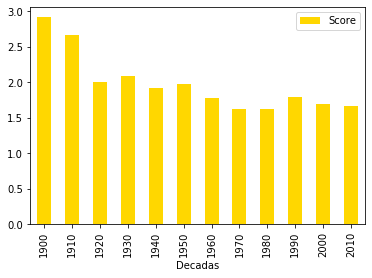

In [47]:
print("Gráfico que muestra la agresividad de Sudáfrica por décadas teniendo en cuenta como hitos importantes:\n 1- Los años 50 (Liga Juvenil del Congreso Nacional) y auge de su activismo\n 2- 1990 (Famoso discurso tras salir de la cárcel)")
b = sud.groupby("Decadas").agg({
    "Score":"mean"   
})
c = b.plot.bar(color='gold')

Obtenemos como conclusión que el porcentaje de ataques fatales en Australia es mayor y que, además, el porcentaje de ataques de Nivel1 en Sudáfrica es mayor que en Australia, por lo que podemos decir que los tiburones de Australia son más agresivos. 
Apreciamos que la agresividad de los tiburones desciende a partir de los años 50 y, aunque hay una subida en los años 90, justo después, vuelve a bajar. 
Así que concluyo con que, aunque los tiburones de Australia parecen más agresivos, no podemos asociar la agresividad al activismo político de Nelson Mandela ni asociar, en general, la influencia de los movimientos sociales de un país al comportamiento de sus animales.